# Chapter 9: Ordinary differential equations

Robert Johansson

Source code listings for [Numerical Python - Scientific Computing and Data Science Applications with Numpy, SciPy and Matplotlib](https://www.apress.com/us/book/9781484242452) (ISBN 978-1-484242-45-2).

In [57]:
import numpy as np

In [58]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.sans-serif'] = 'stix'

In [59]:
import sympy
sympy.init_printing()

In [60]:
from scipy import integrate

## Symbolic ODE solving with SymPy

## Newton's law of cooling

In [ ]:
t, k, T0, Ta = sympy.symbols("t, k, T_0, T_a")

In [ ]:
T = sympy.Function("T")

In [ ]:
ode = T(t).diff(t) + k*(T(t) - Ta)

In [ ]:
ode

In [ ]:
ode_sol = sympy.dsolve(ode)

In [ ]:
ode_sol

In [ ]:
ode_sol.lhs

In [ ]:
ode_sol.rhs

In [ ]:
ics = {T(0): T0}

In [ ]:
ics

In [ ]:
C_eq = ode_sol.subs(t, 0).subs(ics)

In [ ]:
C_eq

In [ ]:
C_sol = sympy.solve(C_eq)

In [ ]:
C_sol

In [ ]:
ode_sol.subs(C_sol[0])

### Function for applying initial conditions

In [ ]:
def apply_ics(sol, ics, x, known_params):
    """
    Apply the initial conditions (ics), given as a dictionary on
    the form ics = {y(0): y0: y(x).diff(x).subs(x, 0): yp0, ...}
    to the solution of the ODE with indepdendent variable x.
    The undetermined integration constants C1, C2, ... are extracted
    from the free symbols of the ODE solution, excluding symbols in
    the known_params list.
    """
    free_params = sol.free_symbols - set(known_params)
    eqs = [(sol.lhs.diff(x, n) - sol.rhs.diff(x, n)).subs(x, 0).subs(ics)
           for n in range(len(ics))]
    sol_params = sympy.solve(eqs, free_params)
    return sol.subs(sol_params)

In [ ]:
ode_sol

In [ ]:
apply_ics(ode_sol, ics, t, [k, Ta])

In [ ]:
ode_sol = apply_ics(ode_sol, ics, t, [k, Ta]).simplify()

In [ ]:
ode_sol

In [ ]:
y_x = sympy.lambdify((t, k), ode_sol.rhs.subs({T0: 5, Ta: 1}), 'numpy')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

x = np.linspace(0, 4, 100)

for k in [1, 2, 3]:
    ax.plot(x, y_x(x, k), label=r"$k=%d$" % k)

ax.set_title(r"$%s$" % sympy.latex(ode_sol), fontsize=18)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$y$", fontsize=18)
ax.legend()

fig.tight_layout()

### Damped harmonic oscillator

In [ ]:
t, omega0 = sympy.symbols("t, omega_0", positive=True)
gamma = sympy.symbols("gamma", complex=True)

In [ ]:
x = sympy.Function("x")

In [ ]:
ode = x(t).diff(t, 2) + 2 * gamma * omega0 * x(t).diff(t) + omega0**2 * x(t)

In [ ]:
ode

In [ ]:
ode_sol = sympy.dsolve(ode)

In [ ]:
ode_sol

In [ ]:
ics = {x(0): 1, x(t).diff(t).subs(t, 0): 0}

In [ ]:
ics

In [ ]:
x_t_sol = apply_ics(ode_sol, ics, t, [omega0, gamma])

In [ ]:
x_t_sol

In [ ]:
x_t_critical = sympy.limit(x_t_sol.rhs, gamma, 1)

In [ ]:
x_t_critical

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

tt = np.linspace(0, 3, 250)
for g in [0.1, 0.5, 1, 2.0, 5.0]:
    if g == 1:
        x_t = sympy.lambdify(t, x_t_critical.subs({omega0: 2.0 * sympy.pi}), 'numpy')
    else:
        x_t = sympy.lambdify(t, x_t_sol.rhs.subs({omega0: 2.0 * sympy.pi, gamma: g}), 'numpy')
    ax.plot(tt, x_t(tt).real, label=r"$\gamma = %.1f$" % g)

ax.set_xlabel(r"$t$", fontsize=18)
ax.set_ylabel(r"$x(t)$", fontsize=18)
ax.set_xlim(0, 3)
ax.legend()

fig.tight_layout()
fig.savefig('ch9-harmonic-oscillator.pdf')

In [ ]:
# example of equation that sympy cannot solve

In [ ]:
x = sympy.symbols("x")

In [ ]:
y = sympy.Function("y")

In [ ]:
f = y(x)**2 + x

In [ ]:
sympy.Eq(y(x).diff(x, x), f)

In [ ]:
# sympy is unable to solve this differential equation
sympy.dsolve(y(x).diff(x, x) - f)

### Direction fields

In [ ]:
def  plot_direction_field(x, y_x, f_xy, x_lim=(-5, 5), y_lim=(-5, 5), ax=None):
    
    f_np = sympy.lambdify((x, y_x), f_xy, 'numpy')
    
    x_vec = np.linspace(x_lim[0], x_lim[1], 20)
    y_vec = np.linspace(y_lim[0], y_lim[1], 20)
    
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4))

    dx = x_vec[1] - x_vec[0]
    dy = y_vec[1] - y_vec[0]

    for m, xx in enumerate(x_vec):
        for n, yy in enumerate(y_vec):
            Dy = f_np(xx, yy) * dx
            Dx = 0.8 * dx**2 / np.sqrt(dx**2 + Dy**2)
            Dy = 0.8 * Dy*dy / np.sqrt(dx**2 + Dy**2)
            ax.plot([xx - Dx/2, xx + Dx/2],
                    [yy - Dy/2, yy + Dy/2], 'b', lw=0.5)
    ax.axis('tight')

    ax.set_title(r"$%s$" %
                 (sympy.latex(sympy.Eq(y(x).diff(x), f_xy))),
                 fontsize=18)
    
    return ax

In [ ]:
x = sympy.symbols("x")

In [ ]:
y = sympy.Function("y")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plot_direction_field(x, y(x), y(x)**2 + x, ax=axes[0])
plot_direction_field(x, y(x), -x / y(x), ax=axes[1])
plot_direction_field(x, y(x), y(x)**2 / x, ax=axes[2])

fig.tight_layout()
fig.savefig('ch9-direction-field.pdf')

### Inexact solutions to ODEs

In [61]:
x = sympy.symbols("x")

In [62]:
y = sympy.Function("y")

In [77]:
f = y(x)**2 + x
# f = sympy.cos(y(x)**2) + x
# f = sympy.sqrt(y(x)) * sympy.cos(x**2)
# f = y(x)**2 / x

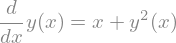

In [78]:
sympy.Eq(y(x).diff(x), f)

In [79]:
ics = {y(0): 0}

In [82]:
ode_sol = sympy.dsolve(y(x).diff(x) - f)

TypeError: bad operand type for unary -: 'list'

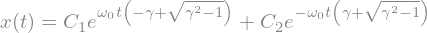

In [84]:
ode_sol

In [85]:
ode_sol = apply_ics(ode_sol, {y(0): 0}, x, [])

KeyError: 0

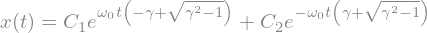

In [83]:
ode_sol

In [86]:
ode_sol = sympy.dsolve(y(x).diff(x) - f, ics=ics)

TypeError: bad operand type for unary -: 'list'

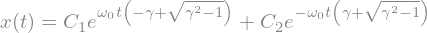

In [87]:
ode_sol

TypeError: loop of ufunc does not support argument 0 of type Add which has no callable sqrt method

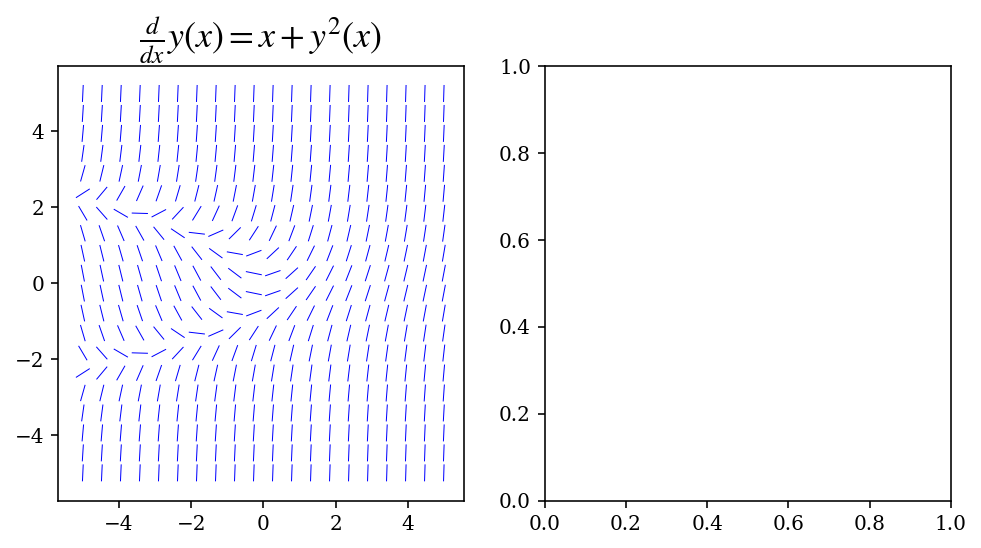

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_direction_field(x, y(x), f, ax=axes[0])
x_vec = np.linspace(-3, 3, 100)
axes[0].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)
axes[0].set_ylim(-5, 5)

plot_direction_field(x, y(x), f, ax=axes[1])
x_vec = np.linspace(-1, 1, 100)
axes[1].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)

ode_sol_m = ode_sol_p = ode_sol
dx = 0.125
for x0 in np.arange(1, 2., dx):
    x_vec = np.linspace(x0, x0 + dx, 100)
    ics = {y(x0): ode_sol_p.rhs.removeO().subs(x, x0)}
    ode_sol_p = sympy.dsolve(y(x).diff(x) - f, ics=ics, n=6)
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_p.rhs.removeO())(x_vec), 'r', lw=2)

for x0 in np.arange(-1, -5, -dx):
    x_vec = np.linspace(x0, x0 - dx, 100)
    ics = {y(x0): ode_sol_m.rhs.removeO().subs(x, x0)}
    ode_sol_m = sympy.dsolve(y(x).diff(x) - f, ics=ics, n=6)
    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_m.rhs.removeO())(x_vec), 'r', lw=2)
    
fig.tight_layout()
fig.savefig("ch9-direction-field-and-approx-sol.pdf")

## Laplace transformation method

In [89]:
t = sympy.symbols("t", positive=True)

In [90]:
s, Y = sympy.symbols("s, Y", real=True)

In [91]:
y = sympy.Function("y")

In [92]:
ode = y(t).diff(t, 2) + 2 * y(t).diff(t) + 10 * y(t) - 2 * sympy.sin(3*t)

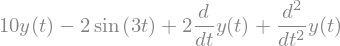

In [93]:
ode

In [94]:
L_y = sympy.laplace_transform(y(t), t, s)

In [95]:
L_y

In [96]:
L_ode = sympy.laplace_transform(ode, t, s, noncods=True)

ValueError: Unknown options: {'noncods': True}

In [ ]:
L_ode

In [ ]:
def laplace_transform_derivatives(e):
    """
    Evaluate the laplace transforms of derivatives of functions
    """
    if isinstance(e, sympy.LaplaceTransform):
        if isinstance(e.args[0], sympy.Derivative):
            d, t, s = e.args
            n = d.args[1][1]
            return ((s**n) * sympy.LaplaceTransform(d.args[0], t, s) - 
                    sum([s**(n-i) * sympy.diff(d.args[0], t, i-1).subs(t, 0)
                         for i in range(1, n+1)]))
        
    if isinstance(e, (sympy.Add, sympy.Mul)):
        t = type(e)
        return t(*[laplace_transform_derivatives(arg) for arg in e.args])
    
    return e

In [ ]:
L_ode

In [ ]:
L_ode_2 = laplace_transform_derivatives(L_ode)

In [ ]:
L_ode_2

In [ ]:
L_ode_3 = L_ode_2.subs(L_y, Y)

In [ ]:
L_ode_3

In [ ]:
ics = {y(0): 1, y(t).diff(t).subs(t, 0): 0}

In [ ]:
ics

In [ ]:
L_ode_4 = L_ode_3.subs(ics)

In [ ]:
L_ode_4

In [ ]:
Y_sol = sympy.solve(L_ode_4, Y)

In [ ]:
Y_sol

In [ ]:
sympy.apart(Y_sol[0])

In [ ]:
y_sol = sympy.inverse_laplace_transform(Y_sol[0], s, t)

In [ ]:
sympy.simplify(y_sol)

In [ ]:
sympy.simplify(y_sol).evalf()

In [ ]:
y_t = sympy.lambdify(t, y_sol.evalf(), 'numpy')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

tt = np.linspace(0, 10, 500)
ax.plot(tt, y_t(tt).real)
ax.set_xlabel(r"$t$", fontsize=18)
ax.set_ylabel(r"$y(t)$", fontsize=18)
fig.tight_layout()

## Numerical integration of ODEs using SciPy

In [ ]:
x = sympy.symbols("x")

In [ ]:
y = sympy.Function("y")

In [ ]:
f = y(x)**2 + x

In [ ]:
f_np = sympy.lambdify((y(x), x), f, 'math')

In [ ]:
y0 = 0

In [ ]:
xp = np.linspace(0, 1.9, 100)

In [ ]:
xp.shape

In [ ]:
yp = integrate.odeint(f_np, y0, xp)

In [ ]:
xm = np.linspace(0, -5, 100)

In [ ]:
ym = integrate.odeint(f_np, y0, xm)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_direction_field(x, y(x), f, ax=ax)
ax.plot(xm, ym, 'b', lw=2)
ax.plot(xp, yp, 'r', lw=2)
fig.savefig('ch9-odeint-single-eq-example.pdf')

## Lotka-Volterra equations for predator/pray populations

$$
x'(t) = a x - b x y
$$

$$
y'(t) = c x y - d y
$$

In [ ]:
a, b, c, d = 0.4, 0.002, 0.001, 0.7

In [ ]:
def f(xy, t):
    x, y = xy
    return [a * x - b * x * y,
            c * x * y - d * y]

In [ ]:
xy0 = [600, 400]

In [ ]:
t = np.linspace(0, 50, 250)

In [ ]:
xy_t = integrate.odeint(f, xy0, t)

In [ ]:
xy_t.shape

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].plot(t, xy_t[:,0], 'r', label="Prey")
axes[0].plot(t, xy_t[:,1], 'b', label="Predator")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Number of animals")
axes[0].legend()

axes[1].plot(xy_t[:,0], xy_t[:,1], 'k')
axes[1].set_xlabel("Number of prey")
axes[1].set_ylabel("Number of predators")
fig.tight_layout()
fig.savefig('ch9-lokta-volterra.pdf')

## Lorenz equations

$$
x'(t) = \sigma(y - x)
$$
$$
y'(t) = x(\rho - z) - y 
$$
$$
z'(t) = x y - \beta z
$$

In [97]:
def f(xyz, t, rho, sigma, beta):
    x, y, z = xyz
    return [sigma * (y - x),
            x * (rho - z) - y,
            x * y - beta * z]

In [98]:
rho = 28.7
sigma = 8
beta = 8/3.0

In [99]:
t = np.linspace(0, 25, 10000)

In [100]:
xyz0 = [1.0, 1.0, 1.0]

In [101]:
xyz1 = integrate.odeint(f, xyz0, t, args=(rho, sigma, beta))

In [103]:
xyz2 = integrate.odeint(f, xyz0, t, args=(rho, sigma, 0.6*beta))

In [104]:
xyz3 = integrate.odeint(f, xyz0, t, args=(rho, 2*sigma, 0.6*beta))

In [105]:
xyz3.shape

In [106]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

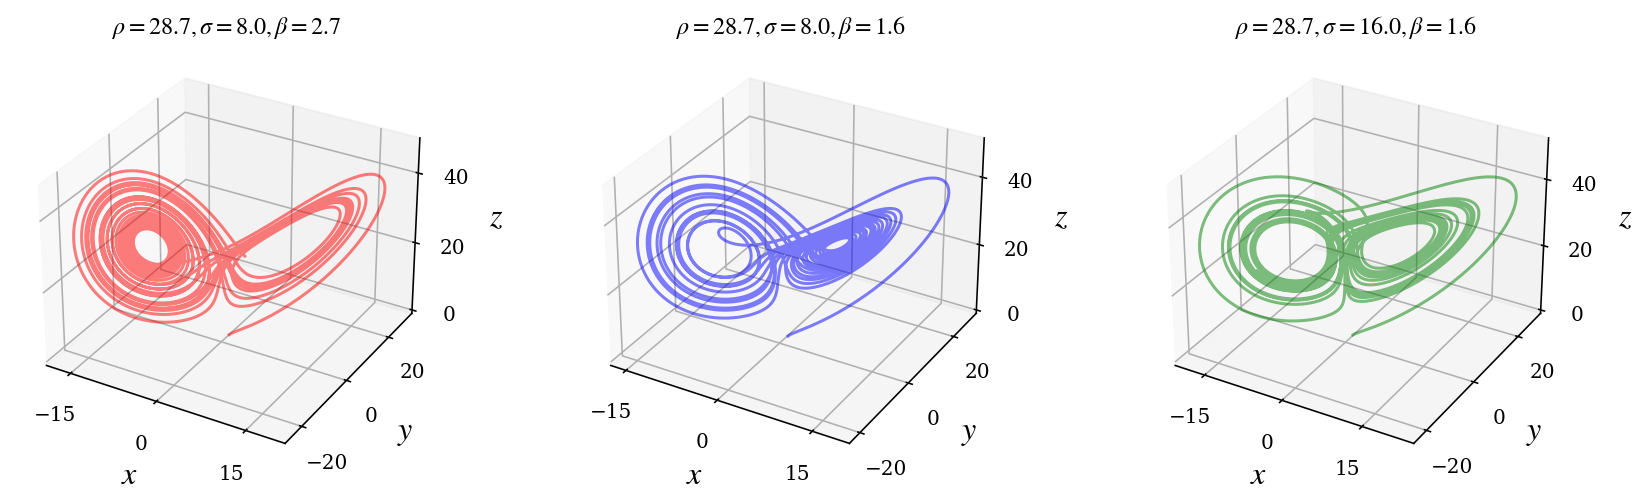

In [107]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5), subplot_kw={'projection': '3d'})

for ax, xyz, c, p in [(ax1, xyz1, 'r', (rho, sigma, beta)),
                      (ax2, xyz2, 'b', (rho, sigma, 0.6*beta)),
                      (ax3, xyz3, 'g', (rho, 2*sigma, 0.6*beta))]:
    ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], c, alpha=0.5)
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16)
    ax.set_zlabel('$z$', fontsize=16)
    ax.set_xticks([-15, 0, 15])
    ax.set_yticks([-20, 0, 20])
    ax.set_zticks([0, 20, 40])
    ax.set_title(r"$\rho=%.1f, \sigma=%.1f, \beta=%.1f$" % (p[0], p[1], p[2]))

fig.tight_layout()
fig.savefig('ch9-lorenz-equations.pdf')

## Coupled damped springs

As second-order equations:

\begin{eqnarray}
m_1 x_1''(t) + \gamma_1 x_1'(t) + k_1 (x_1(t) - l_1) - k_2 (x_2(t) - x_1(t) - l_2) &=& 0\\
m_2 x_2''(t) + \gamma_2 x_2' + k_2 (x_2 - x_1 - l_2) &=& 0
\end{eqnarray}

On standard form:

\begin{align}
y_1'(t) &= y_2(t) \\
y_2'(t) &= -\gamma_1/m_1 y_2(t) - k_1/m_1 (y_1(t) - l_1) + k_2 (y_3(t) - y_1(t) - l_2)/m_1 \\
y_3'(t) &= y_4(t) \\
y_4'(t) &= - \gamma_2 y_4(t)/m_2 - k_2 (y_3(t) - y_1(t) - l_2)/m_2 \\
\end{align}

In [108]:
def f(t, y, args):
    m1, k1, g1, m2, k2, g2 = args
    
    return [y[1], 
            - k1/m1 * y[0] + k2/m1 * (y[2] - y[0]) - g1/m1 * y[1], 
            y[3], 
            - k2/m2 * (y[2] - y[0]) - g2/m2 * y[3] ]

In [109]:
m1, k1, g1 = 1.0, 10.0, 0.5

In [110]:
m2, k2, g2 = 2.0, 40.0, 0.25

In [111]:
args = (m1, k1, g1, m2, k2, g2)

In [112]:
y0 = [1.0, 0, 0.5, 0]

In [113]:
t = np.linspace(0, 20, 1000)

In [114]:
r = integrate.ode(f)

In [115]:
r.set_integrator('lsoda');

In [116]:
r.set_initial_value(y0, t[0]);

In [117]:
r.set_f_params(args);

In [118]:
dt = t[1] - t[0]
y = np.zeros((len(t), len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

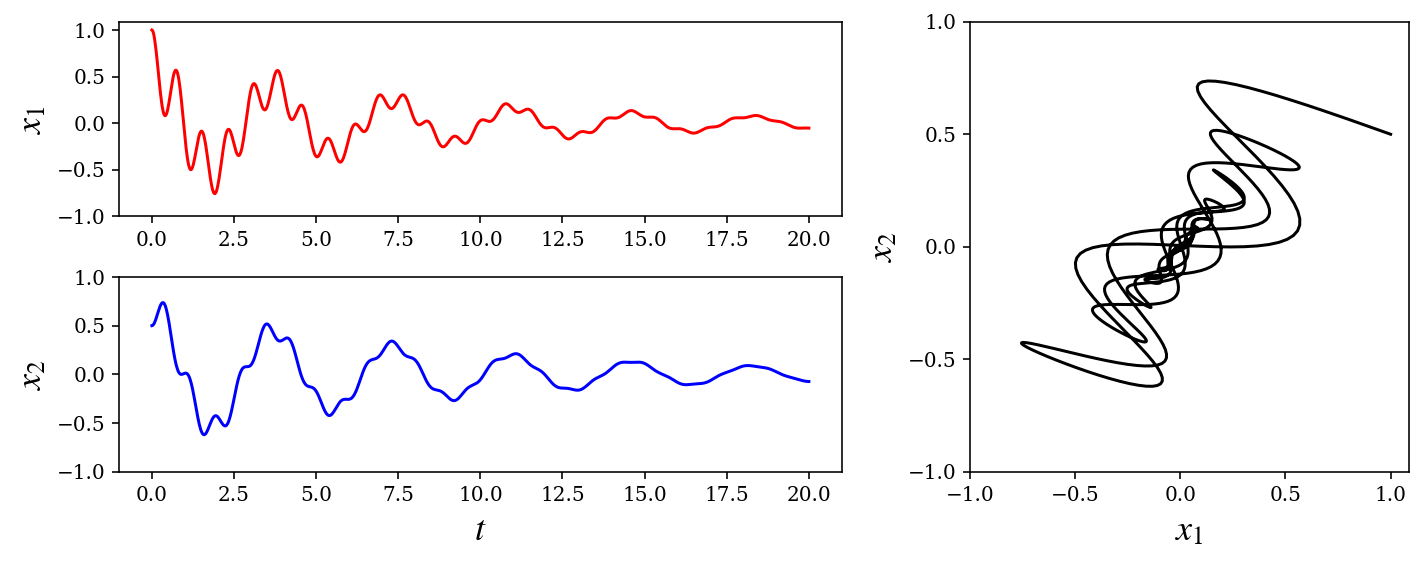

In [119]:
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

ax1.plot(t, y[:, 0], 'r')
ax1.set_ylabel('$x_1$', fontsize=18)
ax1.set_yticks([-1, -.5, 0, .5, 1])

ax2.plot(t, y[:, 2], 'b')
ax2.set_xlabel('$t$', fontsize=18)
ax2.set_ylabel('$x_2$', fontsize=18)
ax2.set_yticks([-1, -.5, 0, .5, 1])

ax3.plot(y[:, 0], y[:, 2], 'k')
ax3.set_xlabel('$x_1$', fontsize=18)
ax3.set_ylabel('$x_2$', fontsize=18)
ax3.set_xticks([-1, -.5, 0, .5, 1])
ax3.set_yticks([-1, -.5, 0, .5, 1])

fig.tight_layout()
fig.savefig('ch9-coupled-damped-springs.pdf')

#### Same calculation as above, but with specifying the Jacobian as well:

In [120]:
def jac(t, y, args):
    m1, k1, g1, m2, k2, g2 = args
    
    return [[0, 1, 0, 0], 
            [- k1/m1 - k2/m1, - g1/m1 * y[1], k2/m1, 0],
            [0, 0, 1, 0],
            [k2/m2, 0, - k2/m2, - g2/m2]]

In [121]:
r = integrate.ode(f, jac).set_f_params(args).set_jac_params(args).set_initial_value(y0, t[0])

In [122]:
dt = t[1] - t[0]
y = np.zeros((len(t), len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

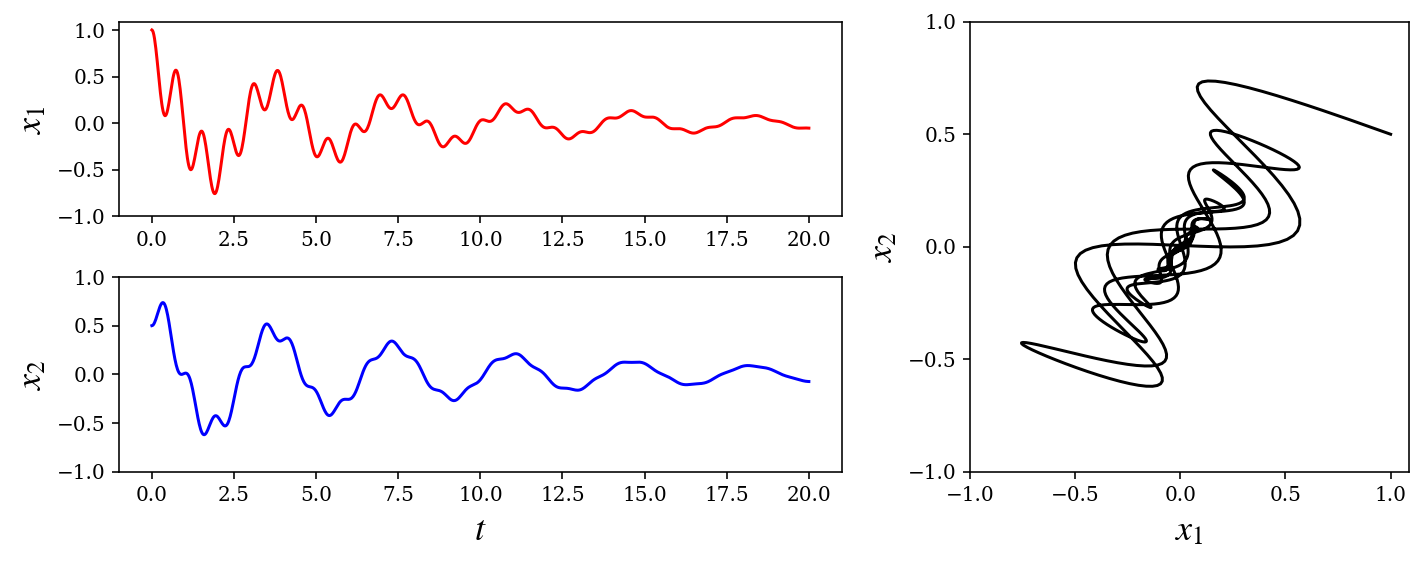

In [123]:
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

ax1.plot(t, y[:, 0], 'r')
ax1.set_ylabel('$x_1$', fontsize=18)
ax1.set_yticks([-1, -.5, 0, .5, 1])

ax2.plot(t, y[:, 2], 'b')
ax2.set_xlabel('$t$', fontsize=18)
ax2.set_ylabel('$x_2$', fontsize=18)
ax2.set_yticks([-1, -.5, 0, .5, 1])

ax3.plot(y[:, 0], y[:, 2], 'k')
ax3.set_xlabel('$x_1$', fontsize=18)
ax3.set_ylabel('$x_2$', fontsize=18)
ax3.set_xticks([-1, -.5, 0, .5, 1])
ax3.set_yticks([-1, -.5, 0, .5, 1])

fig.tight_layout()

### Same calculation, but using SymPy to setup the problem for SciPy

In [124]:
L1 = L2 = 0
t = sympy.symbols("t")
m1, k1, b1 = sympy.symbols("m_1, k_1, b_1")
m2, k2, b2 = sympy.symbols("m_2, k_2, b_2")

In [125]:
x1 = sympy.Function("x_1")
x2 = sympy.Function("x_2")

In [126]:
ode1 = sympy.Eq(m1 * x1(t).diff(t,t,) + b1 * x1(t).diff(t) + k1*(x1(t)-L1) - k2*(x2(t)-x1(t) - L2))

C:\Users\mikol\AppData\Local\Temp/ipykernel_25064/1829674401.py:1: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  ode1 = sympy.Eq(m1 * x1(t).diff(t,t,) + b1 * x1(t).diff(t) + k1*(x1(t)-L1) - k2*(x2(t)-x1(t) - L2))


In [127]:
ode2 = sympy.Eq(m2 * x2(t).diff(t,t,) + b2 * x2(t).diff(t) + k2*(x2(t)-x1(t)-L2))

C:\Users\mikol\AppData\Local\Temp/ipykernel_25064/1686236898.py:1: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  ode2 = sympy.Eq(m2 * x2(t).diff(t,t,) + b2 * x2(t).diff(t) + k2*(x2(t)-x1(t)-L2))


In [128]:
params = {m1: 1.0, k1: 10.0, b1: 0.5,
          m2: 2.0, k2: 40.0, b2: 0.25}

In [129]:
args

In [130]:
y1 = sympy.Function("y_1")
y2 = sympy.Function("y_2")
y3 = sympy.Function("y_3")
y4 = sympy.Function("y_4")

In [131]:
varchange = {x1(t).diff(t, t): y2(t).diff(t), 
             x1(t): y1(t),
             x2(t).diff(t, t): y4(t).diff(t), 
             x2(t): y3(t)}

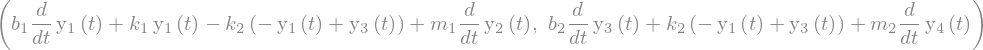

In [132]:
(ode1.subs(varchange).lhs, ode2.subs(varchange).lhs)

In [133]:
ode3 = y1(t).diff(t) - y2(t)

In [134]:
ode4 = y3(t).diff(t) - y4(t)

In [135]:
vcsol = sympy.solve((ode1.subs(varchange), ode2.subs(varchange), ode3, ode4),
                    (y1(t).diff(t), y2(t).diff(t), y3(t).diff(t), y4(t).diff(t)))

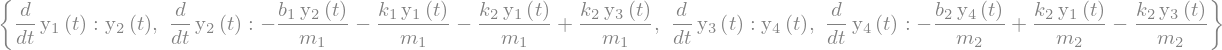

In [136]:
vcsol

In [137]:
ode_rhs = sympy.Matrix([y1(t).diff(t), y2(t).diff(t), y3(t).diff(t), y4(t).diff(t)]).subs(vcsol)

In [138]:
y = sympy.Matrix([y1(t), y2(t), y3(t), y4(t)])

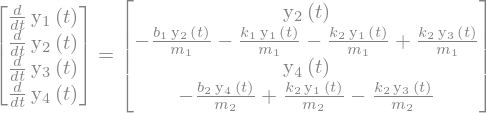

In [139]:
sympy.Eq(y.diff(t), ode_rhs)

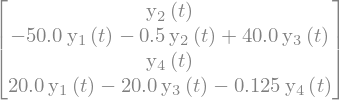

In [140]:
ode_rhs.subs(params)

In [141]:
_f_np = sympy.lambdify((t, y), ode_rhs.subs(params), 'numpy')
f_np = lambda _x, _y, *args: _f_np(_x, _y)

In [142]:
y0 = [1.0, 0, 0.5, 0]
tt = np.linspace(0, 20, 1000)

r = integrate.ode(f_np)
r.set_integrator('lsoda');
r.set_initial_value(y0, tt[0]);

dt = tt[1] - tt[0]
yy = np.zeros((len(tt), len(y0)))
idx = 0
while r.successful() and r.t < tt[-1]:
    yy[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

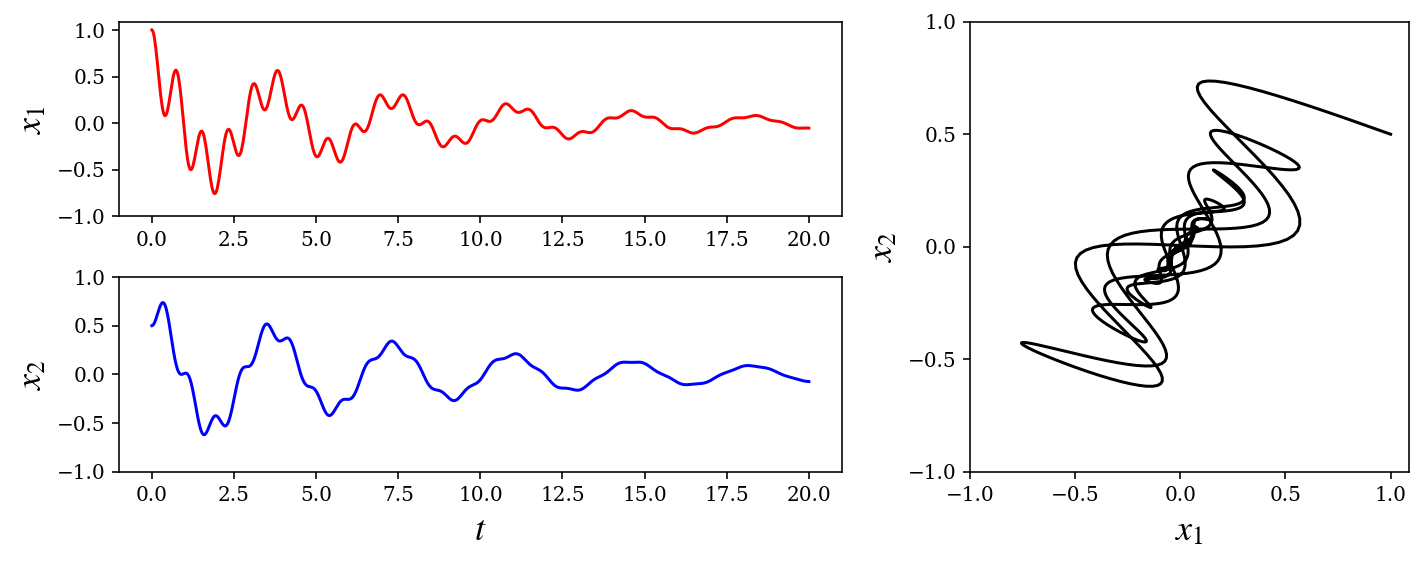

In [143]:
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

ax1.plot(tt, yy[:, 0], 'r')
ax1.set_ylabel('$x_1$', fontsize=18)
ax1.set_yticks([-1, -.5, 0, .5, 1])

ax2.plot(tt, yy[:, 2], 'b')
ax2.set_xlabel('$t$', fontsize=18)
ax2.set_ylabel('$x_2$', fontsize=18)
ax2.set_yticks([-1, -.5, 0, .5, 1])

ax3.plot(yy[:, 0], yy[:, 2], 'k')
ax3.set_xlabel('$x_1$', fontsize=18)
ax3.set_ylabel('$x_2$', fontsize=18)
ax3.set_xticks([-1, -.5, 0, .5, 1])
ax3.set_yticks([-1, -.5, 0, .5, 1])

fig.tight_layout()

## Doube pendulum

http://scienceworld.wolfram.com/physics/DoublePendulum.html

$$
(m_1+m_2) l_1\theta_1'' + m_2l_2\theta_2''\cos(\theta_1-\theta_2)
+ m_2l_2(\theta_2')^2\sin(\theta_1-\theta_2)+g(m_1+m_2)\sin(\theta_1) = 0
$$

$$
m_2l_2\theta_2'' + m_2l_1\theta_1''\cos(\theta_1-\theta_2) - m_2l_1 (\theta_1')^2 \sin(\theta_1-\theta_2)
+m_2g\sin(\theta_2) = 0
$$

In [144]:
t, g, m1, l1, m2, l2 = sympy.symbols("t, g, m_1, l_1, m_2, l_2")

In [145]:
theta1, theta2 = sympy.symbols("theta_1, theta_2", cls=sympy.Function)

C:\Users\mikol\AppData\Local\Temp/ipykernel_25064/4266607674.py:1: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  ode1 = sympy.Eq((m1+m2)*l1 * theta1(t).diff(t,t) +


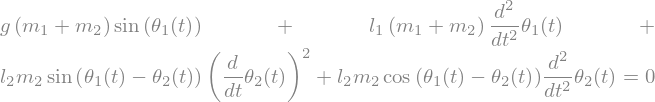

In [146]:
ode1 = sympy.Eq((m1+m2)*l1 * theta1(t).diff(t,t) +
                m2*l2 * theta2(t).diff(t,t) * sympy.cos(theta1(t)-theta2(t))  +
                m2*l2 * theta2(t).diff(t)**2 * sympy.sin(theta1(t)-theta2(t)) + 
                g*(m1+m2) * sympy.sin(theta1(t)))
ode1

C:\Users\mikol\AppData\Local\Temp/ipykernel_25064/1247830998.py:1: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  ode2 = sympy.Eq(m2*l2 * theta2(t).diff(t,t) +


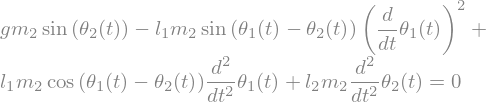

In [147]:
ode2 = sympy.Eq(m2*l2 * theta2(t).diff(t,t) +
                m2*l1 * theta1(t).diff(t,t) * sympy.cos(theta1(t)-theta2(t)) -
                m2*l1 * theta1(t).diff(t)**2 * sympy.sin(theta1(t) - theta2(t)) +
                m2*g * sympy.sin(theta2(t)))
ode2

In [148]:
# this is fruitless, sympy cannot solve these ODEs
try:
    sympy.dsolve(ode1, ode2)
except Exception as e:
    print(e)

cannot determine truth value of Relational


In [149]:
y1, y2, y3, y4 = sympy.symbols("y_1, y_2, y_3, y_4", cls=sympy.Function)

In [150]:
varchange = {theta1(t).diff(t, t): y2(t).diff(t), 
             theta1(t): y1(t),
             theta2(t).diff(t, t): y4(t).diff(t), 
             theta2(t): y3(t)}

In [151]:
ode1_vc = ode1.subs(varchange)

In [152]:
ode2_vc = ode2.subs(varchange)

In [153]:
ode3 = y1(t).diff(t) - y2(t)

In [154]:
ode4 = y3(t).diff(t) - y4(t)

In [155]:
y = sympy.Matrix([y1(t), y2(t), y3(t), y4(t)])

In [156]:
vcsol = sympy.solve((ode1_vc, ode2_vc, ode3, ode4), y.diff(t), dict=True)

In [157]:
f = y.diff(t).subs(vcsol[0])

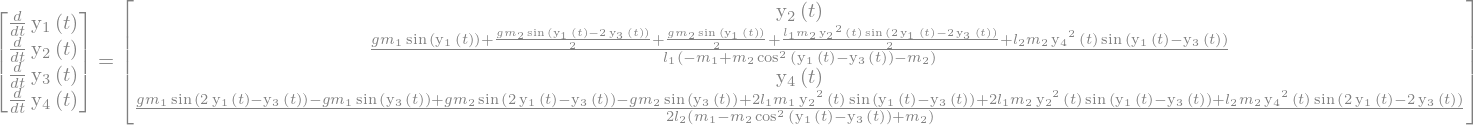

In [158]:
sympy.Eq(y.diff(t), f)

In [159]:
params = {m1: 5.0, l1: 2.0,
          m2: 1.0, l2: 1.0, g: 10.0}

In [160]:
_f_np = sympy.lambdify((t, y), f.subs(params), 'numpy')
f_np = lambda _t, _y, *args: _f_np(_t, _y)

In [161]:
jac = sympy.Matrix([[fj.diff(yi) for yi in y] for fj in f])

In [162]:
_jac_np = sympy.lambdify((t, y), jac.subs(params), 'numpy')
jac_np = lambda _t, _y, *args: _jac_np(_t, _y)

In [163]:
y0 = [2.0, 0, 0.0, 0]

In [164]:
tt = np.linspace(0, 20, 1000)

In [165]:
%%time

r = integrate.ode(f_np, jac_np).set_initial_value(y0, tt[0]);
 
dt = tt[1] - tt[0]
yy = np.zeros((len(tt), len(y0)))
idx = 0
while r.successful() and r.t < tt[-1]:
    yy[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

Wall time: 67 ms


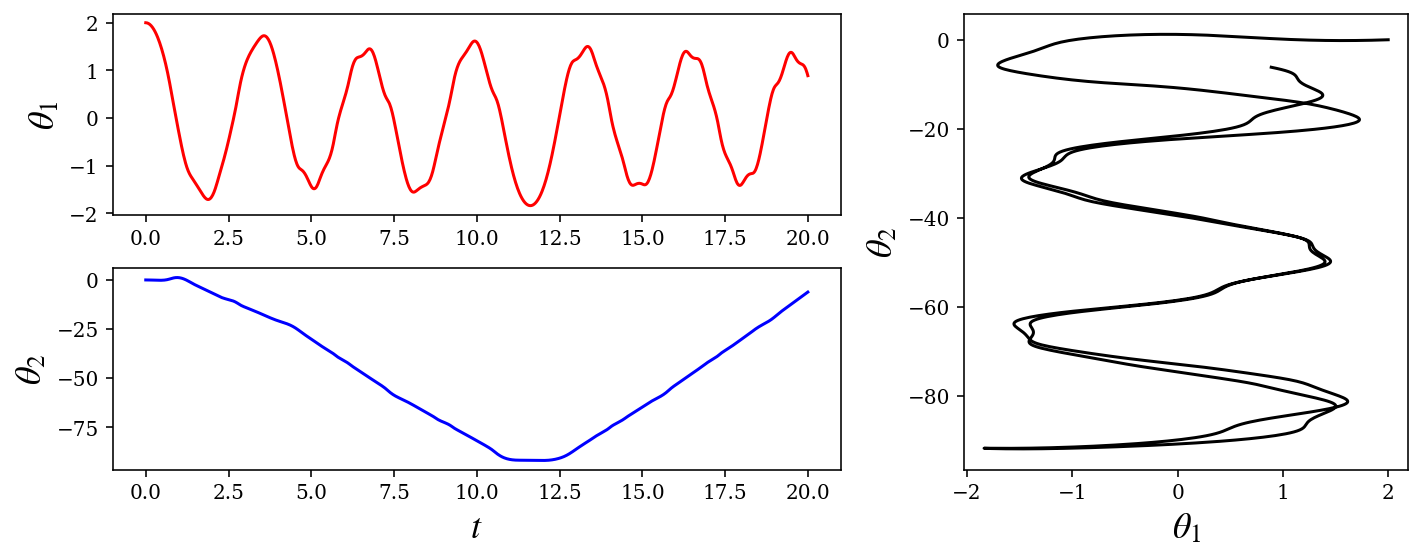

In [166]:
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

ax1.plot(tt, yy[:, 0], 'r')
ax1.set_ylabel(r'$\theta_1$', fontsize=18)

ax2.plot(tt, yy[:, 2], 'b')
ax2.set_xlabel('$t$', fontsize=18)
ax2.set_ylabel(r'$\theta_2$', fontsize=18)

ax3.plot(yy[:, 0], yy[:, 2], 'k')
ax3.set_xlabel(r'$\theta_1$', fontsize=18)
ax3.set_ylabel(r'$\theta_2$', fontsize=18)

fig.tight_layout()

In [168]:
theta1_np, theta2_np = yy[:, 0], yy[:, 2]

In [169]:
x1 = params[l1] * np.sin(theta1_np)
y1 = -params[l1] * np.cos(theta1_np)
x2 = x1 + params[l2] * np.sin(theta2_np)
y2 = y1 - params[l2] * np.cos(theta2_np)

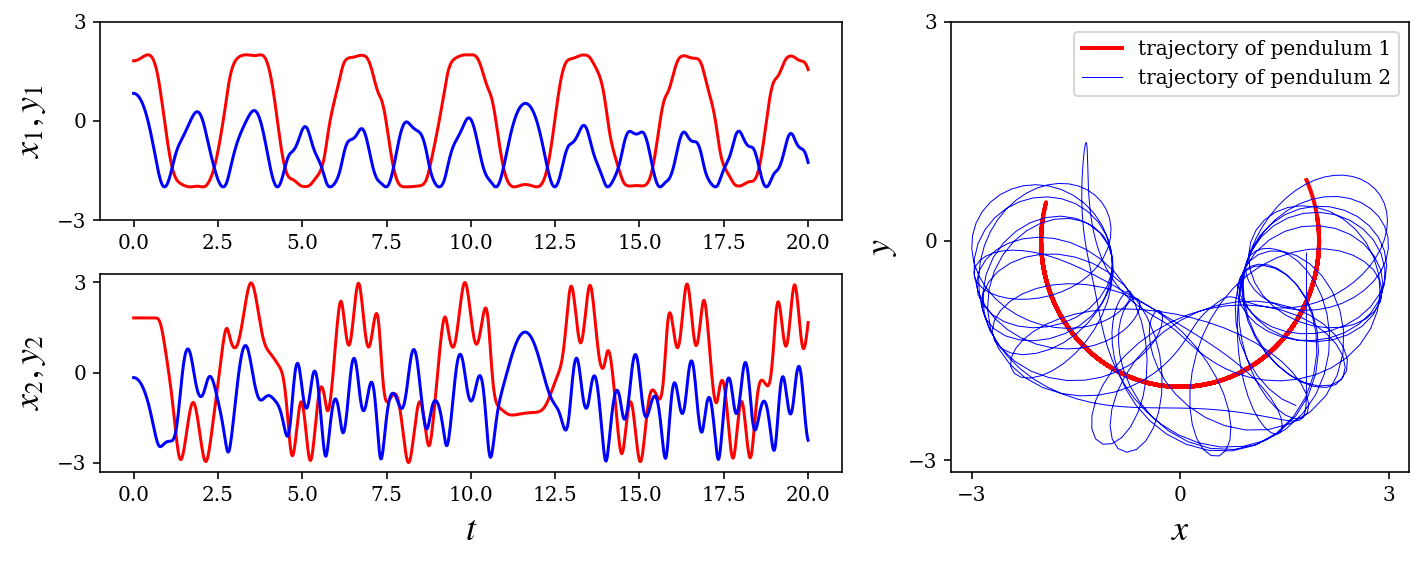

In [170]:
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

ax1.plot(tt, x1, 'r')
ax1.plot(tt, y1, 'b')
ax1.set_ylabel('$x_1, y_1$', fontsize=18)
ax1.set_yticks([-3, 0, 3])

ax2.plot(tt, x2, 'r')
ax2.plot(tt, y2, 'b')
ax2.set_xlabel('$t$', fontsize=18)
ax2.set_ylabel('$x_2, y_2$', fontsize=18)
ax2.set_yticks([-3, 0, 3])

ax3.plot(x1, y1, 'r', lw=2.0, label="trajectory of pendulum 1")
ax3.plot(x2, y2, 'b', lw=0.5, label="trajectory of pendulum 2")
ax3.set_xlabel('$x$', fontsize=18)
ax3.set_ylabel('$y$', fontsize=18)
ax3.set_xticks([-3, 0, 3])
ax3.set_yticks([-3, 0, 3])
ax3.legend()

fig.tight_layout()
fig.savefig('ch9-double-pendulum.pdf')

## Versions

In [ ]:
%reload_ext version_information

In [ ]:
%version_information numpy, scipy, sympy, matplotlib